<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_4_cDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [1]:
import math
import os

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm 

plt.ion()
from IPython.display import clear_output

HYPERPARAMETERS

In [2]:
class Hyperparameters(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=200,
                     batch_size=64,
                     lr=.0002,
                     b1=.5,
                     b2=0.999,
                     n_cpu=8,
                     latent_dim=100,
                     img_size=32,
                     channels=1,
                     n_classes=10,
                     sample_interval=400)

print(hp.lr)

0.0002


SETUP

In [3]:
os.makedirs("images", exist_ok=True)

cuda = True if torch.cuda.is_available() else False
img_shape = (hp.channels, hp.img_size, hp.img_size)

def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find("BatchNorm2d") != -1:
    torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
    torch.nn.init.constant_(m.bias.data, 0.0)

def to_img(x):
  x = x.clamp(0, 1)
  return x

def show_image(img):
  img = to_img(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y):
  with torch.no_grad():  
    images = images.cpu()
    images = to_img(images)
    np_imagegrid = make_grid(images, x, y).numpy()
    figure(figsize=(20,20))
    plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
    plt.show()

GENERATOR

In [4]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.label_emb = nn.Embedding(hp.n_classes, hp.n_classes)

    def block(in_feat, out_feat, normalize=True):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize:
          layers.append(nn.BatchNorm1d(out_feat, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    self.model = nn.Sequential(
      *block(hp.latent_dim + hp.n_classes, 128, normalize=False),
      *block(128, 256),
      *block(256, 512),
      *block(512, 1024),
      nn.Linear(1024, int(np.prod(img_shape))),
      nn.Tanh()
    )

  def forward(self, noise, labels):
    # Concatenate label embedding and image to produce input
    gen_input = torch.cat((self.label_emb(labels), noise), -1)
    img = self.model(gen_input)
    img = img.view(img.size(0), *img_shape)
    return img

DISCRIMINATOR

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_embedding = nn.Embedding(hp.n_classes, hp.n_classes)

    self.model = nn.Sequential(
        nn.Linear(hp.n_classes + int(np.prod(img_shape)), 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 512),
        nn.Dropout(0.4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 1),
    )

  def forward(self, img, labels):
    # Concatenate label embedding and image to produce input
    d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
    validity = self.model(d_in)
    return validity

LOSS and MODELS

In [6]:
loss_fn = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    loss_fn.cuda()

OPTIMIZERS and TENSOR SETUP

In [7]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

GET the DATA

In [8]:
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(hp.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=hp.batch_size,
  shuffle=True,
)

Extracting ../../data/mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/mnist/FashionMNIST/raw


Extracting ../../data/mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/mnist/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
def sample_image(n_row, batches_done):    
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, hp.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    visualise_output(gen_imgs.data[:50],10, 10)
    #save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

TRAINING

Epoch:102/724:DLoss0.23845747113227844:GLoss0.2484891563653946


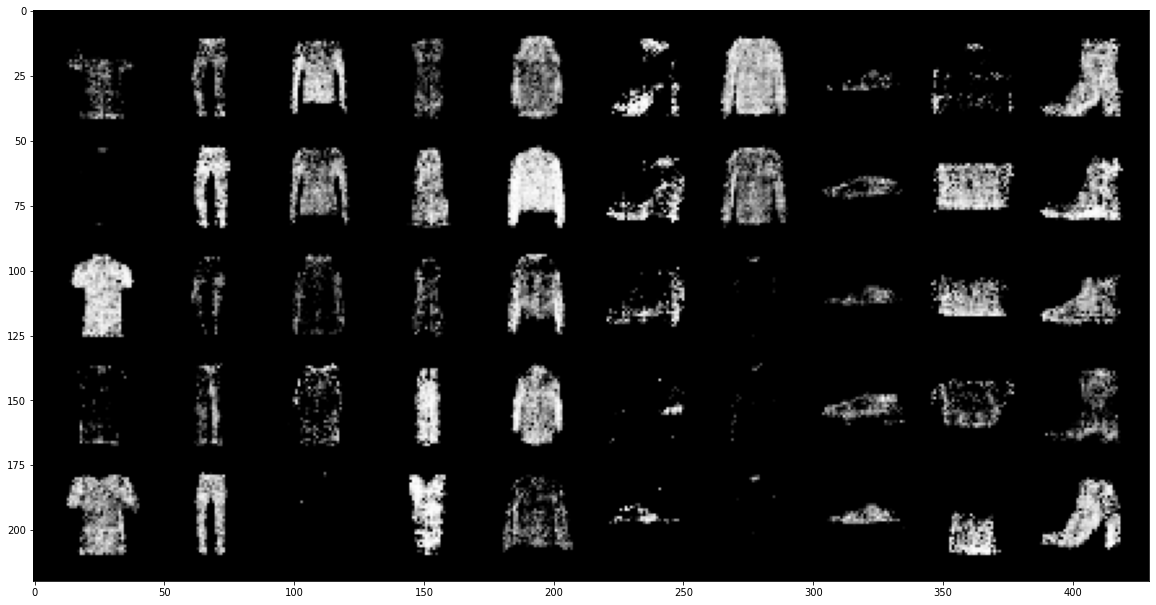

In [ ]:
for epoch in range(hp.n_epochs):
  for i, (imgs, labels) in enumerate(dataloader):

      batch_size = imgs.shape[0]

      # Adversarial ground truths
      valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
      fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

      # Configure input
      real_imgs = Variable(imgs.type(FloatTensor))
      labels = Variable(labels.type(LongTensor))

      # -----------------
      #  Train Generator
      # -----------------

      optimizer_G.zero_grad()

      # Sample noise and labels as generator input
      z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, hp.latent_dim))))
      gen_labels = Variable(LongTensor(np.random.randint(0, hp.n_classes, batch_size)))      
      # Generate a batch of images
      gen_imgs = generator(z, gen_labels)

      # Loss measures generator's ability to fool the discriminator
      validity = discriminator(gen_imgs, gen_labels)
      g_loss = loss_fn(validity, valid)

      g_loss.backward()
      optimizer_G.step()

      # ---------------------
      #  Train Discriminator
      # ---------------------

      optimizer_D.zero_grad()

      # Loss for real images
      validity_real = discriminator(real_imgs, labels)
      d_real_loss = loss_fn(validity_real, valid)

      # Loss for fake images
      validity_fake = discriminator(gen_imgs.detach(), gen_labels)
      d_fake_loss = loss_fn(validity_fake, fake)

      # Total discriminator loss
      d_loss = (d_real_loss + d_fake_loss) / 2

      d_loss.backward()
      optimizer_D.step()


      batches_done = epoch * len(dataloader) + i
      if batches_done % hp.sample_interval == 0:
        clear_output()
        print(f"Epoch:{epoch}/{i}:DLoss{d_loss.item()}:GLoss{g_loss.item()}") 
        sample_image(n_row=10, batches_done=batches_done)                 